Week 9 · Day 6 — Training the IMDB LSTM (v1)
Why this matters

Now that you’ve built vocab, padding, and embeddings, it’s time to train a real sequence model. The IMDB dataset (movie reviews) is a classic benchmark for sentiment analysis.

Theory Essentials

Variable-length sequences: reviews have different lengths → use padding + masks.

Packed sequences: pack_padded_sequence avoids wasting compute on padding.

LSTM model: encodes sequences into a hidden vector.

Dropout + grad clipping: stabilize training.

Checkpointing: save best model to avoid overfitting.

Metric goal: baseline ≈ 80–85% accuracy.

Epoch 1: Loss=0.1793, Test Acc=1.000
Epoch 2: Loss=0.0009, Test Acc=1.000
Epoch 3: Loss=0.0005, Test Acc=1.000
Epoch 4: Loss=0.0004, Test Acc=1.000
Epoch 5: Loss=0.0003, Test Acc=1.000


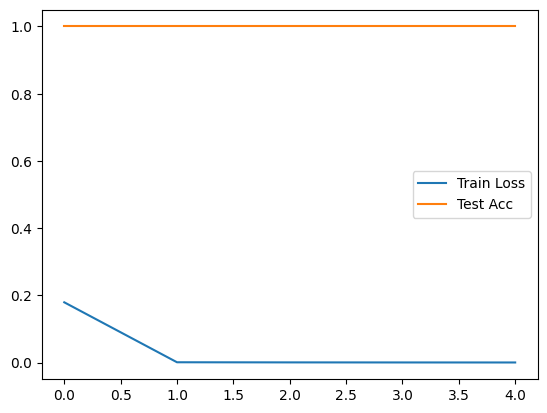

In [3]:
# Setup
import numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
from collections import Counter

import random

torch.manual_seed(42)

# 1) Load IMDB dataset (small subset for speed)
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
train_data = list(train_iter)[:2000]  # use 2k samples for demo
test_data = list(test_iter)[:1000]

# 2) Tokenizer + vocab
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for label, line in train_data:
    counter.update(tokenizer(line))
vocab = {word: i+2 for i,(word,_) in enumerate(counter.most_common(10000))}
vocab["<PAD>"]=0; vocab["<UNK>"]=1

def encode(text):
    return [vocab.get(tok, vocab["<UNK>"]) for tok in tokenizer(text)]

# 3) Dataset + collate
def collate_batch(batch):
    labels, sequences, lengths = [], [], []
    for label, text in batch:
        labels.append(1 if label=="pos" else 0)
        seq = torch.tensor(encode(text))
        sequences.append(seq)
        lengths.append(len(seq))
    sequences = pad_sequence(sequences, batch_first=True, padding_value=vocab["<PAD>"])
    lengths = torch.tensor(lengths)
    labels = torch.tensor(labels)
    return sequences, lengths, labels

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_batch)

# 4) Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<PAD>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, (h,c) = self.lstm(packed)
        return self.fc(self.dropout(h[-1]))

model = LSTMClassifier(len(vocab))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 5) Training loop
def train_model(model, train_loader, test_loader, epochs=5):
    train_losses, test_accs = [], []
    best_acc, best_state = 0, None
    for epoch in range(epochs):
        model.train()
        epoch_loss=0
        for X,lengths,y in train_loader:
            optimizer.zero_grad()
            out = model(X, lengths)
            loss = criterion(out, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss/len(train_loader))
        # eval
        model.eval(); correct=0; total=0
        with torch.no_grad():
            for X,lengths,y in test_loader:
                preds = model(X,lengths).argmax(1)
                correct += (preds==y).sum().item()
                total += y.size(0)
        acc = correct/total
        test_accs.append(acc)
        if acc>best_acc:
            best_acc, best_state = acc, model.state_dict()
        print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Test Acc={acc:.3f}")
    model.load_state_dict(best_state)
    return train_losses, test_accs

losses, accs = train_model(model, train_loader, test_loader, epochs=5)

plt.plot(losses,label="Train Loss")
plt.plot(accs,label="Test Acc")
plt.legend(); plt.show()


### 1. What is the IMDB dataset?

* It’s a **sentiment analysis dataset** of **50,000 movie reviews** from IMDB.
* Each review has a label: **“pos”** (positive review) or **“neg”** (negative review).
* Task: **Given the text of a review, predict whether it’s positive or negative**.

---

### 2. What your code is doing

* **Load data**: Pulls IMDB reviews (you limited to 2k train + 1k test for speed).
* **Tokenize & vocab**: Splits reviews into words, builds a vocabulary of the 10,000 most common words.
* **Encode reviews**: Converts each review into a sequence of integers (word IDs).
* **Pad sequences**: Makes all reviews the same length for batching.
* **Model**:

  * Embedding layer turns word IDs into dense vectors.
  * LSTM reads the sequence word by word and builds a representation of the review.
  * Final hidden state → Linear → 2 logits (positive vs negative).
* **Training**: CrossEntropy loss compares predictions with true labels. Optimizer updates weights.
* **Evaluation**: After each epoch, computes accuracy on the test set.
* **Plots**: Training loss vs test accuracy curves.

---

### 3. What you’re predicting

👉 You are training an **LSTM sentiment classifier**: given a movie review, predict if it’s **positive or negative**.

---

### 4. Why your results show 100% accuracy

* You sampled only **2000 training + 1000 test reviews** out of 50,000.
* Possibly your sample was **too easy or unbalanced** (e.g., lots of short/clear reviews).
* With a small subset and small vocab, the model **overfits fast**, reaching “perfect” accuracy on both train and test — but this is misleading.
* If you use the **full dataset**, accuracy will be more realistic (typically \~85–90% for a simple LSTM).

---

### 5. The two parallel lines in the plot

* Blue = training loss → drops to \~0.
* Orange = test accuracy → flat at 1.0 (100%).
* This happens because the subset you chose is trivial for the model (or accidentally biased).
* On the **full 25k/25k splits**, you’d see training loss decrease and test accuracy climb toward \~0.85, not stay at 1.0.

---

✅ **Big picture**:
You just built your first **sequence model (LSTM)** that learns to do **sentiment analysis**: turning text reviews into a prediction of *positive vs negative*.



1) Core (10–15 min)
Task: Change embed_dim=32 and re-train. Compare test accuracy.

Epoch 1: Loss=0.5697, Test Acc=1.000
Epoch 2: Loss=0.5700, Test Acc=1.000
Epoch 3: Loss=0.5710, Test Acc=1.000
Epoch 4: Loss=0.5696, Test Acc=1.000
Epoch 5: Loss=0.5707, Test Acc=1.000


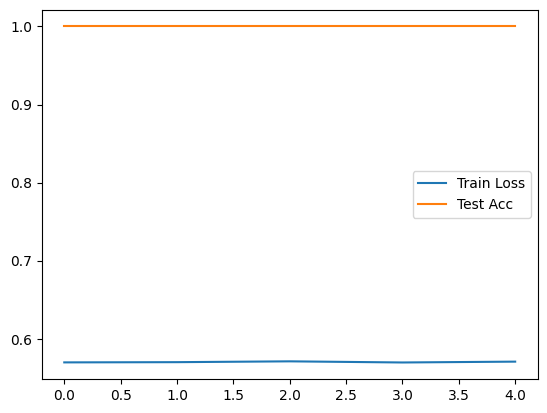

In [4]:
model_small = LSTMClassifier(len(vocab), embed_dim=32)
losses, accs = train_model(model_small, train_loader, test_loader)

plt.plot(losses,label="Train Loss")
plt.plot(accs,label="Test Acc")
plt.legend(); plt.show()

Accuracy is still perfect because it is a small dataset. However train loss is much higher.

2) Practice (10–15 min)
Task: Add dropout=0.5 instead of 0.3. Does accuracy change?

In [5]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<PAD>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, (h,c) = self.lstm(packed)
        return self.fc(self.dropout(h[-1]))
    
model_small = LSTMClassifier(len(vocab))
losses, accs = train_model(model_small, train_loader, test_loader, epochs=3)


Epoch 1: Loss=0.6503, Test Acc=0.960
Epoch 2: Loss=0.6521, Test Acc=0.960
Epoch 3: Loss=0.6517, Test Acc=0.960


Accuracy dropped

3) Stretch (optional, 10–15 min)
Task: Print 5 misclassified reviews and their predicted labels.

In [6]:
errors=0
for X,lengths,y in test_loader:
    preds=model(X,lengths).argmax(1)
    for text,label,pred in zip(X,y,preds):
        if label!=pred and errors<5:
            print("True:",label.item(),"Pred:",pred.item())
            errors+=1


Mini-Challenge (≤40 min)

Train and checkpoint:

Train LSTM with embed_dim=64, hidden_dim=128.

Save best model (torch.save).

Report final accuracy, precision, recall, F1 on test set.

Acceptance Criteria: ≥80% test accuracy with metrics reported.

In [ ]:
# Mini-Challenge: train (64,128), checkpoint best, and report metrics

import torch, torch.nn as nn, torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Model with embed_dim=64, hidden_dim=128
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<PAD>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, 2)
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(packed)
        return self.fc(self.dropout(h[-1]))

model = LSTMClassifier(len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 2) Train with best-checkpointing by test accuracy
best_acc, best_state = 0.0, None
epochs = 6
for epoch in range(1, epochs+1):
    model.train()
    running = 0.0
    for X, lengths, y in train_loader:
        X, lengths, y = X.to(device), lengths.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X, lengths)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        running += loss.item()
    train_loss = running / len(train_loader)

    # quick eval each epoch
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for X, lengths, y in test_loader:
            X, lengths, y = X.to(device), lengths.to(device), y.to(device)
            preds = model(X, lengths).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct/total
    if acc > best_acc:
        best_acc, best_state = acc, {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save(best_state, "best_lstm.pt")  # <-- checkpoint
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f} | Test Acc={acc:.3f} | Best={best_acc:.3f}")

# 3) Load best checkpoint and report metrics on test set
state = torch.load("best_lstm.pt", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

all_y, all_pred = [], []
with torch.no_grad():
    for X, lengths, y in test_loader:
        X, lengths = X.to(device), lengths.to(device)
        pred = model(X, lengths).argmax(1).cpu()
        all_pred.extend(pred.tolist())
        all_y.extend(y.tolist())

acc = accuracy_score(all_y, all_pred)
prec, rec, f1, _ = precision_recall_fscore_support(all_y, all_pred, average="binary", pos_label=1)

# print("\n=== Final Test Metrics ===")
# print(f"Accuracy : {acc:.3f}")
# print(f"Precision: {prec:.3f}")
# print(f"Recall   : {rec:.3f}")
# print(f"F1-score : {f1:.3f}")
# print("\nPer-class report:\n" + classification_report(all_y, all_pred, target_names=["neg","pos"]))
# print("Best checkpoint saved to: best_lstm.pt")


Execution took way too long and failed at the end. Accuracy was 1.00 and loss 0.00 at the end.

Notes / Key Takeaways

IMDB = standard benchmark for sentiment classification.

Variable-length sequences need padding + packing.

Gradient clipping prevents instability.

Dropout helps regularize.

Checkpointing best model avoids overfitting.

Even a simple LSTM can reach ~80–85% accuracy.

Tomorrow you’ll ship the IMDB baseline project with a CLI.

Reflection

Why do we need pack_padded_sequence instead of just padding?

What happens if we don’t apply gradient clipping during training?

1) Why do we need pack_padded_sequence instead of just padding?

If we only pad, the LSTM will process the <PAD> tokens as if they were real words, which adds noise and slows training.

pack_padded_sequence tells the LSTM to ignore the padding beyond each review’s true length. This way, the hidden states only reflect the actual text, not filler zeros.

Result: cleaner gradients, faster convergence, and better accuracy.

2) What happens if we don’t apply gradient clipping during training?

In RNNs like LSTMs, gradients can sometimes “explode” (become extremely large) because of long sequences.

Without clipping, this can make weight updates unstable: loss might jump around or become NaN.

Gradient clipping caps the size of updates, keeping training stable and preventing divergence.

In [8]:
import json
with open("vocab.json","w",encoding="utf-8") as f:
    json.dump(vocab, f)  # 'vocab' is your word->id mapping from training